# Data prep
This is a notebook to read in raw datasets and transform them into datasets for a neural network. <br>
Steps done:<br>

    - Interpolating WRF parts to same grid and extent
    - Interpolating NCEP to WRF 3km grid
    - Coarsening WRF 9km back to its original grid from the 3km grid
    - Coarsening NCEP to an 18km grid from the 3km grid
    - Writing data to .tfrecord files

In [1]:
# data
import netCDF4 as nc
import numpy as np

import pandas as pd

# models 
import tensorflow as tf
print(tf.__version__)
tf.disable_eager_execution()
#tf.enable_eager_execution()

# must be True
print(tf.executing_eagerly())

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os

import helper_functions as hf
from skimage.metrics import structural_similarity as ssim

import importlib as imp

1.13.1
False


Module helper_functions contains self-made and are kept there to make this document more readable. To reload the module after changes to any of its functions use the imp.reload(hf) function below.

In [2]:
imp.reload(hf)

<module 'helper_functions' from 'C:\\Users\\SWFva\\OneDrive\\Documents\\Studie\\Thesis\\code\\helper_functions.py'>

### Reading in the datasets

#### WRF 9 KM

In [12]:
# coordinates
c1 = nc.Dataset('data/raw/coordinates_9km_famke_part1.nc')
c2 = nc.Dataset('data/raw/coordinates_9km_famke_part2.nc')

lat_WRF_9km_part1 = np.array(c1['XLAT'][0])
lon_WRF_9km_part1 = np.array(c1['XLONG'][0])

lat_WRF_9km_part2 = np.array(c2['XLAT'][0])
lon_WRF_9km_part2 = np.array(c2['XLONG'][0])

In [14]:
# data
ds1 = nc.Dataset('data/raw/wrfout_9km_famke_1part.nc')
ds2 = nc.Dataset('data/raw/wrfout_9km_famke_2part.nc')

# temperature
T_WRF_9km_part1 = np.array(ds1['T2'])
T_WRF_9km_part2 = np.array(ds2['T2'])

# u-component of wind
U_WRF_9km_part1 = np.array(ds1['U10'])
U_WRF_9km_part2 = np.array(ds2['U10'])

# v-component of wind
V_WRF_9km_part1 = np.array(ds1['V10'])
V_WRF_9km_part2 = np.array(ds2['V10'])

In [15]:
T_WRF_9km_part1.shape

(1552, 89, 93)

#### WRF 3 km

In [3]:
c3 = nc.Dataset('data/raw/Coordinates_3km_part1.nc')
c4 = nc.Dataset('data/raw/Coordinates_3km_part2.nc')

lat_WRF_3km_part1 = np.array(c3['XLAT'][0])[:,0:96]
lon_WRF_3km_part1 = np.array(c3['XLONG'][0])[:,0:96]

lat_WRF_3km_part2 = np.array(c4['XLAT'][0])
lon_WRF_3km_part2 = np.array(c4['XLONG'][0])

lat_WRF_3km_part1.shape

(96, 96)

In [17]:
# data
ds3 = nc.Dataset('data/raw/wrfout_3km_1part_3h.nc')
ds4 = nc.Dataset('data/raw/wrfout_3km_2part_3h.nc')

# temperature
T_WRF_3km_part1 = np.array(ds3['T2'])[:,:,0:96]
T_WRF_3km_part2 = np.array(ds4['T2'])

# u-component of wind
U_WRF_3km_part1 = np.array(ds3['U10'])[:,:,0:96]
U_WRF_3km_part2 = np.array(ds4['U10'])

# v-component of wind
V_WRF_3km_part1 = np.array(ds3['V10'])[:,:,0:96]
V_WRF_3km_part2 = np.array(ds4['V10'])

To visualise the study area extent the following code can be used to get a polygon.

In [12]:
# shapely export T_WRF extent as bounding box
from osgeo import ogr,osr
from shapely.geometry import Point, Polygon
import shapely.wkt

point_list = []
zero_i = 0

for j in range(lon_WRF_3km_part1.shape[0]):
    for i in range(lon_WRF_3km_part1.shape[0]):
        if (i == 0):
            point_list.append(Point(lon_WRF_3km_part1[i,j],lat_WRF_3km_part1[i,j]))
        elif (i == lon_WRF_3km_part1.shape[0]-1):
            point_list.append(Point(lon_WRF_3km_part1[i,j],lat_WRF_3km_part1[i,j]))
        elif (j == 0):
            point_list.append(Point(lon_WRF_3km_part1[i,j],lat_WRF_3km_part1[i,j]))
        elif (j == lon_WRF_3km_part1.shape[0]-1):
            point_list.append(Point(lon_WRF_3km_part1[i,j],lat_WRF_3km_part1[i,j]))
        else:
            continue
    continue

P = Polygon(point_list)


print(str(P))

POLYGON ((8.7867431640625 44.73132705688477, 8.785675048828125 44.75843048095703, 8.784637451171875 44.7855224609375, 8.7835693359375 44.81261444091797, 8.78253173828125 44.83971786499023, 8.781463623046875 44.86680603027344, 8.7803955078125 44.89389801025391, 8.779327392578125 44.92100143432617, 8.778289794921875 44.94809341430664, 8.7772216796875 44.97520065307617, 8.776153564453125 45.00229263305664, 8.77508544921875 45.02939224243164, 8.774017333984375 45.05648422241211, 8.77294921875 45.08358764648438, 8.77191162109375 45.11067962646484, 8.770843505859375 45.13777542114258, 8.769775390625 45.16487884521484, 8.768707275390625 45.19197463989258, 8.767608642578125 45.21907424926758, 8.76654052734375 45.24616622924805, 8.765472412109375 45.27326965332031, 8.764404296875 45.30036163330078, 8.763336181640625 45.32746887207031, 8.76226806640625 45.35456466674805, 8.76116943359375 45.38165664672852, 8.760101318359375 45.40876388549805, 8.759033203125 45.43585586547852, 8.7579345703125 45.

#### WRF Test data

In [20]:
ds5 = nc.Dataset('data/raw/wrfout_9km_2021.nc')
ds6 = nc.Dataset('data/raw/wrfout_3km_2021_3h.nc')

In [21]:
# temperature
T_WRF_9km_test_raw = np.array(ds5['T2'])
T_WRF_3km_test_raw = np.array(ds6['T2'])

# u-component of wind
U_WRF_9km_test_raw = np.array(ds5['U10'])
U_WRF_3km_test_raw = np.array(ds6['U10'])

# v-component of wind
V_WRF_9km_test_raw = np.array(ds5['V10'])
V_WRF_3km_test_raw = np.array(ds6['V10'])

T_WRF_9km_test_raw.shape, T_WRF_3km_test_raw.shape

((2920, 192, 147), (2920, 147, 198))

#### NCEP GFS dataset

In [22]:
ds_NCEP = nc.Dataset('data/raw/NCEP_merged.nc')

# coordinates
lat_NCEP = np.array(ds_NCEP['lat'])
lon_NCEP = np.array(ds_NCEP['lon'])

#data
T_NCEP = ds_NCEP['TMP_L103']
U_NCEP = ds_NCEP['U_GRD_L103']
V_NCEP = ds_NCEP['V_GRD_L103']

T_NCEP.shape

(4131, 41, 65)

In [23]:
if(len(lat_NCEP.shape)==1):
    lon_NCEP, lat_NCEP = np.meshgrid(lon_NCEP, lat_NCEP)

lon_NCEP.shape

(41, 65)

NCEP test

In [24]:
ds_NCEP_test = nc.Dataset('data/raw/NCEP_merged_test.nc')

# coordinates
lat_NCEP_test = np.array(ds_NCEP_test['lat'])
lon_NCEP_test = np.array(ds_NCEP_test['lon'])

#data
T_NCEP_test = ds_NCEP_test['TMP_L103']
U_NCEP_test = ds_NCEP_test['U_GRD_L103']
V_NCEP_test = ds_NCEP_test['V_GRD_L103']

T_NCEP_test.shape

(2921, 29, 37)

In [25]:
if(len(lat_NCEP_test.shape)==1):
    lon_NCEP_test, lat_NCEP_test = np.meshgrid(lon_NCEP_test, lat_NCEP_test)

lon_NCEP_test.shape

(29, 37)

#### Time

For time data I used a season index using the following short algorithm. Time and elevation data was not used in the final model since to use any metadata in this model one would need to stack the data.  Stacking different variables does require min-max normalisation to have the different variables on the same scale. But this resulted in low performance since the final produced superresolutions are on a different scale.

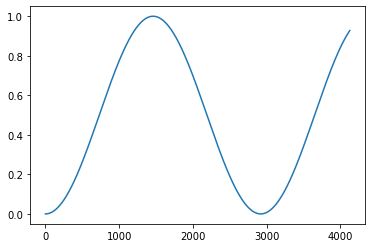

In [15]:
import math as m

time = []

for t in range(4128):
    time.append(m.sin(m.pi*t/2920)**2)
    
plt.plot(time)
plt.show()

In [16]:
time_arr = np.zeros((4128,96,96),dtype='float32')
for t in range(time_arr.shape[0]):
    time_arr[t,:,:] = time[t]

time_arr.shape

(4128, 96, 96)

#### DEM

In [17]:
dem_ds = nc.Dataset('data/raw/DEM.nc')
dem_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    GDAL_AREA_OR_POINT: Area
    GDAL_TIFFTAG_ARTIST: Giuseppe Amatulli (giuseppe.amatulli@yale.edu , giuseppe.amatulli@gmail.com)
    GDAL_TIFFTAG_DATETIME: 2016
    GDAL_TIFFTAG_DOCUMENTNAME: 30 arc-seconds Maximum elevation
    GDAL_TIFFTAG_IMAGEDESCRIPTION: 30 arc-seconds Maximum elevation derived from GMTED2010 Maximum Statistic, 7.5 arc-seconds prduct
    GDAL_TIFFTAG_SOFTWARE: gdal 1.10.0 & pktools 2.6.4 & GRASS7
    Conventions: CF-1.5
    GDAL: GDAL 3.0.2, released 2019/10/28
    history: Thu May 26 19:48:45 2022: GDAL CreateCopy( data/DEM.nc, ... )
    dimensions(sizes): lon(4320), lat(1680)
    variables(dimensions): |S1 crs(), float64 lat(lat), float64 lon(lon), float32 Band1(lat,lon)
    groups: 

In [18]:
DEM = np.array(dem_ds['Band1'])
DEM.shape

(1680, 4320)

In [19]:
lon_DEM = dem_ds['lon']
lat_DEM = dem_ds['lat']

if(len(lat_DEM.shape)==1):
    lon_DEM, lat_DEM = np.meshgrid(lon_DEM, lat_DEM)

lon_DEM.shape

(1680, 4320)

### Interpolating to same extent

This is done by changing longitude and latitude coordinates of the datasets to a cartesian grid and using nearest neighbor interpolation to get all data on the same grid (WRF 3km).

In [26]:
# target cartesian coordinates
xt, yt, zt = hf.lon_lat_to_cartesian(lon_WRF_3km_part1.flatten(), lat_WRF_3km_part1.flatten())

#### WRF 9 km

In [28]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_9km_part1.flatten(), lat_WRF_9km_part1.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [29]:
# nearest neighbor
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_WRF_9km_part1_near = hf.transform_extent(T_WRF_9km_part1, inds, lat_WRF_3km_part1.shape)
U_WRF_9km_part1_near = hf.transform_extent(U_WRF_9km_part1, inds, lat_WRF_3km_part1.shape)
V_WRF_9km_part1_near = hf.transform_extent(V_WRF_9km_part1, inds, lat_WRF_3km_part1.shape)

In [30]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_9km_part2.flatten(), lat_WRF_9km_part2.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [31]:
# nearest neighbor
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_WRF_9km_part2_near = hf.transform_extent(T_WRF_9km_part2, inds, lat_WRF_3km_part1.shape)
U_WRF_9km_part2_near = hf.transform_extent(U_WRF_9km_part2, inds, lat_WRF_3km_part1.shape)
V_WRF_9km_part2_near = hf.transform_extent(V_WRF_9km_part2, inds, lat_WRF_3km_part1.shape)

Concatenating the two 9km WRF datasets to 1

In [32]:
T_WRF_9km = np.concatenate((T_WRF_9km_part1_near, T_WRF_9km_part2_near))
U_WRF_9km = np.concatenate((U_WRF_9km_part1_near, U_WRF_9km_part2_near))
V_WRF_9km = np.concatenate((V_WRF_9km_part1_near, V_WRF_9km_part2_near))

print(T_WRF_9km.shape)

(4128, 96, 96)


Test data 9 km

In [33]:
T_WRF_9km_test = hf.transform_extent(T_WRF_9km_test_raw, inds, lat_WRF_3km_part1.shape)
U_WRF_9km_test = hf.transform_extent(U_WRF_9km_test_raw, inds, lat_WRF_3km_part1.shape)
V_WRF_9km_test = hf.transform_extent(V_WRF_9km_test_raw, inds, lat_WRF_3km_part1.shape)

T_WRF_9km_test.shape

(2920, 96, 96)

#### WRF 3km

In [34]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_3km_part2.flatten(), lat_WRF_3km_part2.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [35]:
# nearest neighbor
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_WRF_3km_part2_near = hf.transform_extent(T_WRF_3km_part2, inds, lat_WRF_3km_part1.shape)
U_WRF_3km_part2_near = hf.transform_extent(U_WRF_3km_part2, inds, lat_WRF_3km_part1.shape)
V_WRF_3km_part2_near = hf.transform_extent(V_WRF_3km_part2, inds, lat_WRF_3km_part1.shape)

Concatenating the two 3km WRF datasets to 1

In [36]:
T_WRF_3km = np.concatenate((T_WRF_3km_part1, T_WRF_3km_part2_near))
U_WRF_3km = np.concatenate((U_WRF_3km_part1, U_WRF_3km_part2_near))
V_WRF_3km = np.concatenate((V_WRF_3km_part1, V_WRF_3km_part2_near))

Test data 3km

In [38]:
T_WRF_3km_test = hf.transform_extent(T_WRF_3km_test_raw, inds, lat_WRF_3km_part1.shape)
U_WRF_3km_test = hf.transform_extent(U_WRF_3km_test_raw, inds, lat_WRF_3km_part1.shape)
V_WRF_3km_test = hf.transform_extent(V_WRF_3km_test_raw, inds, lat_WRF_3km_part1.shape)

T_WRF_3km_test.shape

(2920, 96, 96)

#### NCEP

In [ ]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_NCEP.flatten(), lat_NCEP.flatten())

tree = cKDTree(np.column_stack((xs, ys, zs)))

In [ ]:
# nearest neighbour
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_NCEP_near = hf.transform_extent(T_NCEP, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]
U_NCEP_near = hf.transform_extent(U_NCEP, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]
V_NCEP_near = hf.transform_extent(V_NCEP, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]

NCEP test

In [ ]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_NCEP_test.flatten(), lat_NCEP_test.flatten())

tree = cKDTree(np.column_stack((xs, ys, zs)))

In [ ]:
# nearest neighbour
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

T_NCEP_test_near = hf.transform_extent(T_NCEP_test, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km_test.shape[0]]
U_NCEP_test_near = hf.transform_extent(U_NCEP_test, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km_test.shape[0]]
V_NCEP_test_near = hf.transform_extent(V_NCEP_test, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km_test.shape[0]]

In [ ]:
T_NCEP_test_near.shape

#### DEM

In [32]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_DEM.flatten(), lat_DEM.flatten())

tree = cKDTree(np.column_stack((xs, ys, zs)))

In [33]:
# nearest neighbour
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

DEM_near = hf.transform_extent(DEM, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]
DEM_near.shape

(96, 96)

In [223]:
DEM_norm = hf.minmax_norm(DEM_near)
np.max(DEM_norm)

1.0

#### Deleting raw datasets to save RAM space

In [314]:
del c1
del c2
del c3
del c4

In [315]:
del ds1, ds2, ds3, ds4, ds5, ds6

In [321]:
del T_WRF_9km_part1, T_WRF_9km_part2
del U_WRF_9km_part1, U_WRF_9km_part2
del V_WRF_9km_part1, V_WRF_9km_part2

NameError: name 'T_WRF_9km_part1' is not defined

In [320]:
del T_WRF_3km_part1, T_WRF_3km_part2
del U_WRF_3km_part1, U_WRF_3km_part2
del V_WRF_3km_part1, V_WRF_3km_part2

NameError: name 'T_WRF_3km_part1' is not defined

In [318]:
del xs, xt, ys, yt, zs, zt
del d, inds

### Downscaling

Current model is doing downscaling by increasing the pixel count, so it wants a low pixel count image and increase the pixel count by an integer factor. For us the low resolution to medium resolution is 16x16 pixels to 32x32. And medium to high resolution is 32x32 to 96x96. 

In [380]:
# Train
T_WRF_9km_down = hf.downscale_image(T_WRF_9km, 3)
U_WRF_9km_down = hf.downscale_image(U_WRF_9km, 3)
V_WRF_9km_down = hf.downscale_image(V_WRF_9km, 3)

T_NCEP_down = hf.downscale_image(T_NCEP_near, 6)
U_NCEP_down = hf.downscale_image(U_NCEP_near, 6)
V_NCEP_down = hf.downscale_image(V_NCEP_near, 6)


# Test
T_NCEP_test_down = hf.downscale_image(T_NCEP_test_near, 6)
U_NCEP_test_down = hf.downscale_image(U_NCEP_test_near, 6)
V_NCEP_test_down = hf.downscale_image(V_NCEP_test_near, 6)

T_WRF_9km_down.shape, T_NCEP_down.shape, T_NCEP_test_down.shape

((4128, 32, 32, 1), (4128, 16, 16, 1), (2920, 16, 16, 1))

### Writing data to .npy for analysis

We should save the data to numpy arrays so we can read them later in analysis scripts.

In [335]:
# TRAIN

# WRF 3km
np.save('data/analysis/T_WRF_3km.npy', T_WRF_3km)
np.save('data/analysis/U_WRF_3km.npy', U_WRF_3km)
np.save('data/analysis/V_WRF_3km.npy', V_WRF_3km)

# WRF 9km
np.save('data/analysis/T_WRF_9km.npy', T_WRF_9km)
np.save('data/analysis/U_WRF_9km.npy', U_WRF_9km)
np.save('data/analysis/V_WRF_9km.npy', V_WRF_9km)

# NCEP native
np.save('data/analysis/T_NCEP_near.npy', T_NCEP_near)
np.save('data/analysis/U_NCEP_near.npy', U_NCEP_near)
np.save('data/analysis/V_NCEP_near.npy', V_NCEP_near)

# NCEP down
np.save('data/analysis/T_NCEP_down.npy', T_NCEP_down)
np.save('data/analysis/U_NCEP_down.npy', U_NCEP_down)
np.save('data/analysis/V_NCEP_down.npy', V_NCEP_down)



In [398]:
# TEST

# WRF 3km
np.save('data/analysis/T_WRF_3km_test.npy', T_WRF_3km_test)
np.save('data/analysis/U_WRF_3km_test.npy', U_WRF_3km_test)
np.save('data/analysis/V_WRF_3km_test.npy', V_WRF_3km_test)

# WRF 9km
np.save('data/analysis/T_WRF_9km_test.npy', T_WRF_9km_test)
np.save('data/analysis/U_WRF_9km_test.npy', U_WRF_9km_test)
np.save('data/analysis/V_WRF_9km_test.npy', V_WRF_9km_test)

# NCEP

# NCEP down
np.save('data/analysis/T_NCEP_test_down.npy', T_NCEP_test_down)
np.save('data/analysis/U_NCEP_test_down.npy', U_NCEP_test_down)
np.save('data/analysis/V_NCEP_test_down.npy', V_NCEP_test_down)

### Writing data to .tfrecord

The current model is implemented with reading data from a .tfrecord which is an Tensorflow data format.

#### Normal data sets

In [400]:
print(T_WRF_9km_down.shape, T_NCEP_down.shape)

# Train
hf.generate_TFRecords(filename = 'G:/Mijn Drive/Studie/thesis/data/model/T_lr_mr.tfrecord',
                   data_HR = T_WRF_9km_down,
                   data_LR = T_NCEP_down,
                   mode = 'train')

# Test
hf.generate_TFRecords(filename = 'G:/Mijn Drive/Studie/thesis/data/model/T_lr_mr_test.tfrecord',
                   data_HR = None,
                   data_LR = T_NCEP_test_down,
                   mode = 'test')


(4128, 32, 32, 1) (4128, 16, 16, 1)


In [392]:
U_WRF_9km_down.shape

(4128, 32, 32, 1)

In [399]:
# Stacking wind data
Wind_WRF_9km = np.squeeze(np.stack([U_WRF_9km_down, V_WRF_9km_down], axis = -1))
Wind_NCEP = np.squeeze(np.stack([U_NCEP_down, V_NCEP_down], axis=-1))
Wind_NCEP_test = np.squeeze(np.stack([U_NCEP_test_down, V_NCEP_test_down], axis=-1))
    
print(Wind_WRF_9km.shape, Wind_NCEP.shape, Wind_NCEP_test.shape)

(4128, 32, 32, 2) (4128, 16, 16, 2) (2920, 16, 16, 2)


In [397]:
# Train
hf.generate_TFRecords(filename = 'G:/Mijn Drive/Studie/thesis/data/model/Wind_lr_mr.tfrecord',
                   data_HR = Wind_WRF_9km,
                   data_LR = Wind_NCEP,
                   mode = 'train')

# Test
hf.generate_TFRecords(filename = 'G:/Mijn Drive/Studie/thesis/data/model/Wind_lr_mr_test.tfrecord',
                   data_HR = None,
                   data_LR = Wind_NCEP_test,
                   mode = 'test')

#### Making MR - HR dataset

Stacking wind 3km components to a single array.

In [42]:
# Stacking wind data
Wind_WRF_3km = np.squeeze(np.stack([U_WRF_3km, V_WRF_3km], axis = -1))
Wind_WRF_3km_test = np.squeeze(np.stack([U_WRF_3km_test, V_WRF_9km_test], axis = -1))
    
print(Wind_WRF_3km.shape, Wind_WRF_3km_test.shape)

(4128, 96, 96, 2) (2920, 96, 96, 2)


In [4]:
# getting the generated MR data
# temperature
T_mr = np.load('G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR/train/cnn00037/dataSR.npy')      
T_mr_test = np.load('G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR/test/cnn00037/dataSR.npy')

T_mr.shape, T_mr_test.shape

((4128, 32, 32, 1), (2920, 32, 32, 1))

In [3]:
# wind
Wind_mr = np.load('G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train/cnn00007/dataSR.npy')      
Wind_mr_test = np.load('G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/test/cnn00007/dataSR.npy')

Wind_mr.shape, Wind_mr_test.shape

((4128, 32, 32, 2), (2920, 32, 32, 2))

Writing the generated MR and the 3km data to a .tfrecord dataset.

In [5]:
# Train
hf.generate_TFRecords(filename = 'G:/Mijn Drive/Studie/thesis/data/model/T_mr_hr.tfrecord',
                   data_HR = T_WRF_3km,
                   data_LR = T_mr,
                   mode = 'train')

# Test
hf.generate_TFRecords(filename = 'G:/Mijn Drive/Studie/thesis/data/model/T_mr_hr_test.tfrecord',
                   data_HR = None,
                   data_LR = T_mr_test,
                   mode = 'test')

In [6]:
# Train
hf.generate_TFRecords(filename = 'G:/Mijn Drive/Studie/thesis/data/model/Wind_mr_hr.tfrecord',
                   data_HR = Wind_WRF_3km,
                   data_LR = Wind_mr,
                   mode = 'train')

# Test
hf.generate_TFRecords(filename = 'G:/Mijn Drive/Studie/thesis/data/model/Wind_mr_hr_test.tfrecord',
                   data_HR = None,
                   data_LR = Wind_mr_test,
                   mode = 'test')